In [1]:
pip install kagglehub

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   -------------------------- ------------- 1.3/2.0 MB 6.7 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.6 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ---------------------------------------- 0.0/2.2 M

In [2]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.filters import gabor
from skimage.util import invert
from scipy.ndimage import gaussian_filter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")

print("Path to dataset files:", path)

main_dir = os.path.join(path, 'dataset_blood_group')

blood_groups = ["A+", "A-", "AB+", "AB-", "B+", "B-", "O+", "O-"]

dataset = {group: [os.path.join(main_dir, group, file) for file in os.listdir(os.path.join(main_dir, group))]
           for group in blood_groups}

E:\anaconda\envs\rao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 58.1M/58.1M [00:12<00:00, 4.84MB/s]

Extracting files...


Path to dataset files: C:\Users\laksh\.cache\kagglehub\datasets\rajumavinmar\finger-print-based-blood-group-dataset\versions\1


# Fingerprint Feature Extraction Steps
1. Preprocessing
2. Segmentation
3. Orientation Field Estimation
4. Frequency Estimation
5. Gabor Filtering (Enhancement)
6. Binarization and Thinning
6. Minutiae Extraction
7. Pattern Type Classification

# 1. Display the Sample images 

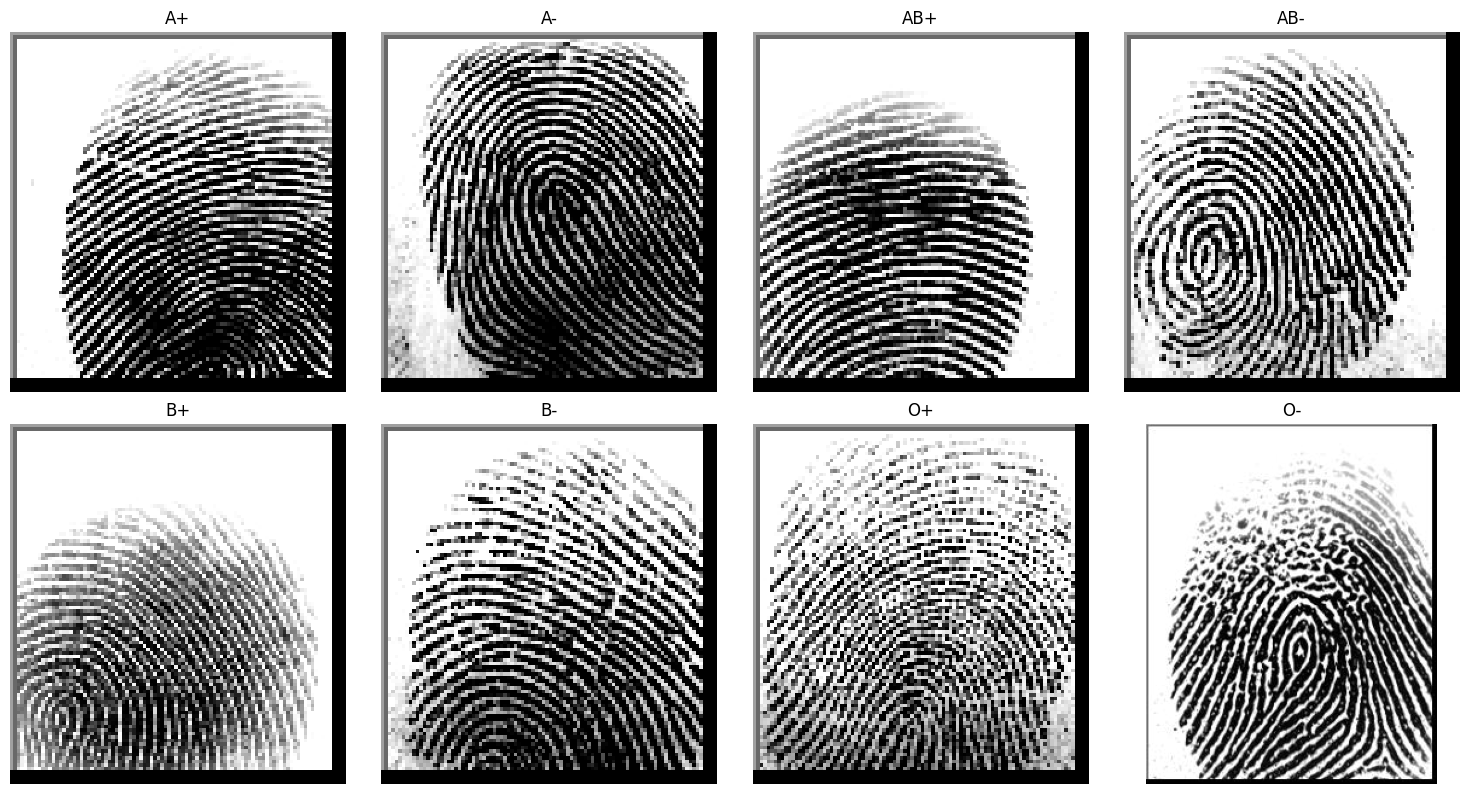

In [3]:
# Display one sample image from each blood group
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, group in enumerate(blood_groups):
    sample_image_path = dataset[group][0]
    image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(group)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# **2. Preprocessing**
1. Crop Borders
2. Histogram equilization for contrast stretching
2. Normalize the images


In [4]:
import cv2

def crop_borders(image, top=10, bottom=10, left=10, right=10):
    return image[top:image.shape[0]-bottom, left:image.shape[1]-right]

def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def load_images(dataset):
    all_images = {}
    for group, paths in dataset.items():
        all_images[group] = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths]
    return all_images

def equilize_images(image):
    return cv2.equalizeHist(image)


def process_images(dataset):
    all_images = load_images(dataset)
    processed_images = {}
    for group, images in all_images.items():
        processed_images[group] = [
                normalize_image(
                    equilize_images(
                        crop_borders(image)
                    )
                )
            for image in images
        ]
    return processed_images


# Assume `dataset` is a dictionary with keys as groups (e.g., "A", "B", etc.)
# and values as lists of file paths to images.
processed_images = process_images(dataset)
print("Cropping, normalization, and Gaussian noise removal completed.")


Cropping, normalization, and Gaussian noise removal completed.


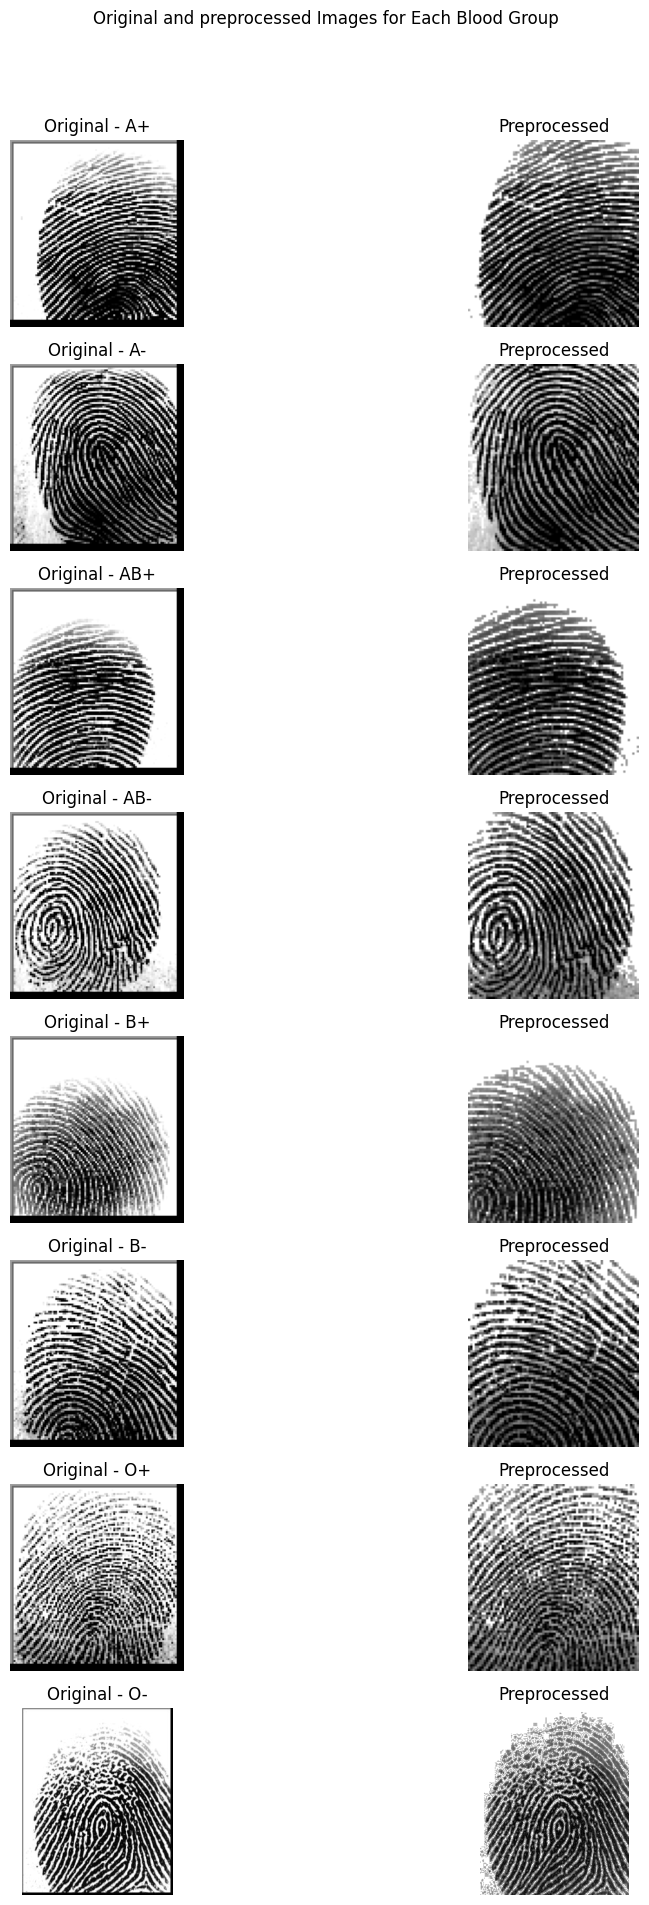

In [5]:
# Display original, cropped, and normalized images for one sample per group
fig, axs = plt.subplots(len(blood_groups), 2, figsize=(12, 20))
fig.suptitle("Original and preprocessed Images for Each Blood Group")

for i, group in enumerate(blood_groups):
    # Original
    original_image = cv2.imread(dataset[group][0], cv2.IMREAD_GRAYSCALE)
    axs[i, 0].imshow(original_image, cmap='gray')
    axs[i, 0].set_title(f"Original - {group}")
    
    # Normalized
    preprocessed_image = processed_images[group][0]
    axs[i, 1].imshow(preprocessed_image, cmap='gray')
    axs[i, 1].set_title("Preprocessed")
    
    # Turn off axis for all subplots
    for ax in axs[i, :]:
        ax.axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Orientation Estimation

In [6]:
# Function to estimate orientation for all images
def apply_orientation_estimation(images):
    orientation_images = {}
    for group, imgs in images.items():
        orientation_images[group] = [np.arctan2(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5),
                                                cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)) * 180 / np.pi
                                     for img in imgs]
    return orientation_images

# Estimate orientation for all images
orientation_images = apply_orientation_estimation(processed_images)
print("Orientation estimation completed.")

Orientation estimation completed.


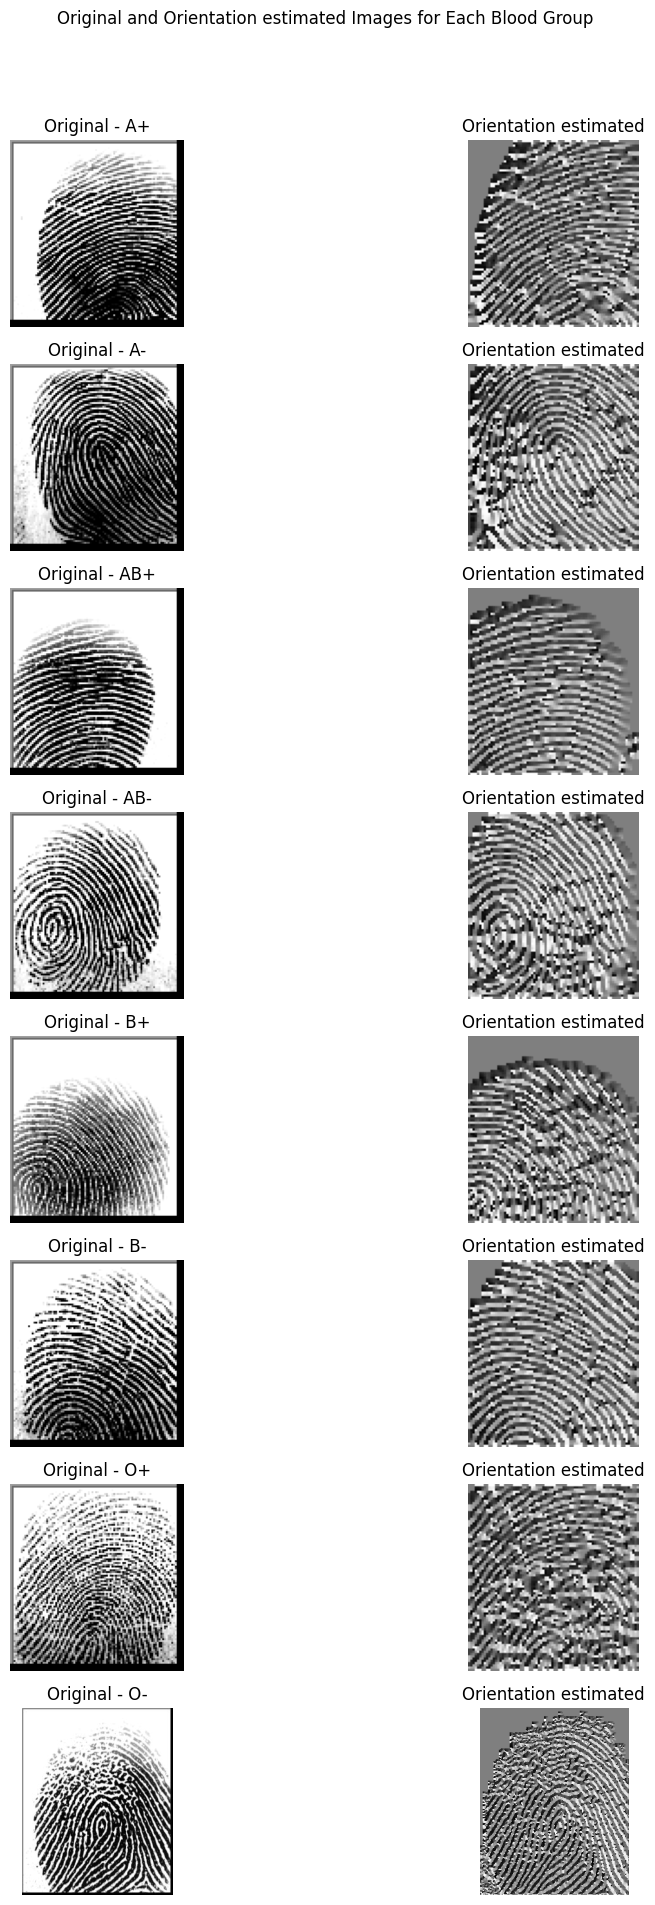

In [7]:
# Display original, cropped, and normalized images for one sample per group
fig, axs = plt.subplots(len(blood_groups), 2, figsize=(12, 20))
fig.suptitle("Original and Orientation estimated Images for Each Blood Group")

for i, group in enumerate(blood_groups):
    # Original
    original_image = cv2.imread(dataset[group][0], cv2.IMREAD_GRAYSCALE)
    axs[i, 0].imshow(original_image, cmap='gray')
    axs[i, 0].set_title(f"Original - {group}")
    
    # Normalized
    orientation_image = orientation_images[group][0]
    axs[i, 1].imshow(orientation_image, cmap='gray')
    axs[i, 1].set_title("Orientation estimated")
    
    # Turn off axis for all subplots
    for ax in axs[i, :]:
        ax.axis('off')

    # Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Ridge Frequency Estimation

In [8]:
# Function to estimate ridge frequency for all images
def apply_ridge_frequency_estimation(images):
    frequency_images = {}
    for group, imgs in images.items():
        frequency_images[group] = [20 * np.log(np.abs(np.fft.fftshift(np.fft.fft2(img))) + 1)
                                   for img in imgs]
    return frequency_images

# Apply ridge frequency estimation for all images
frequency_images = apply_ridge_frequency_estimation(processed_images)
print("Ridge frequency estimation completed.")

Ridge frequency estimation completed.


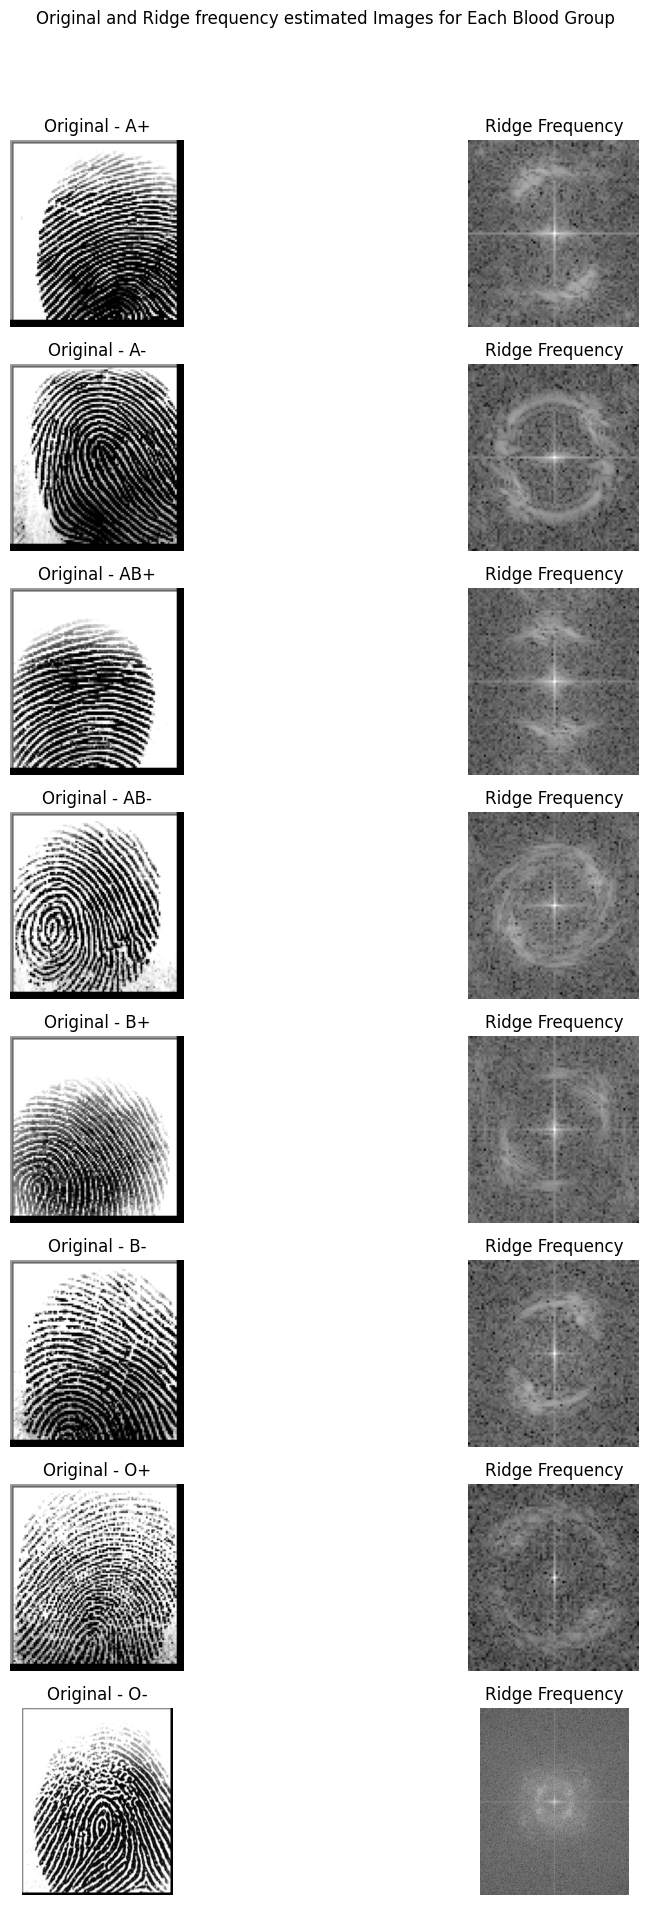

In [9]:
# Display original, cropped, and normalized images for one sample per group
fig, axs = plt.subplots(len(blood_groups), 2, figsize=(12, 20))
fig.suptitle("Original and Ridge frequency estimated Images for Each Blood Group")

for i, group in enumerate(blood_groups):
    # Original
    original_image = cv2.imread(dataset[group][0], cv2.IMREAD_GRAYSCALE)
    axs[i, 0].imshow(original_image, cmap='gray')
    axs[i, 0].set_title(f"Original - {group}")
    
    
    frequency_image = frequency_images[group][0]
    axs[i, 1].imshow(frequency_image, cmap='gray')
    axs[i, 1].set_title("Ridge Frequency")
    
    # Turn off axis for all subplots
    for ax in axs[i, :]:
        ax.axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Compute orientation maps

In [10]:
import math


def compute_orientation_maps(images, block_size=10):
   
    orientation_maps = {}
    for group, imgs in images.items():
        group_maps = []
        for image in imgs:
            rows, cols = image.shape

            # Calculate the number of blocks
            num_blocks_y = math.ceil(rows / block_size)
            num_blocks_x = math.ceil(cols / block_size)

            # Initialize orientation map for the current image
            orientation_map = np.zeros((num_blocks_y, num_blocks_x))
            gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
            gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

            for i in range(num_blocks_y):
                for j in range(num_blocks_x):
                    y_start = i * block_size
                    y_end = min((i + 1) * block_size, rows)
                    x_start = j * block_size
                    x_end = min((j + 1) * block_size, cols)

                    block_x = gradient_x[y_start:y_end, x_start:x_end]
                    block_y = gradient_y[y_start:y_end, x_start:x_end]

                    # Compute dominant orientation in the block
                    Gxx = np.sum(block_x ** 2)
                    Gyy = np.sum(block_y ** 2)
                    Gxy = np.sum(block_x * block_y)
                    theta = 0.5 * np.arctan2(2 * Gxy, Gxx - Gyy)
                    orientation_map[i, j] = theta

            group_maps.append(orientation_map)
        orientation_maps[group] = group_maps

    return orientation_maps


# Compute orientation maps for all groups of images
block_size = 10
orientation_maps = compute_orientation_maps(processed_images, block_size)
print("Orientation maps computation completed.")


Orientation maps computation completed.


# Gabor Enhancement

In [11]:
def apply_gabor_filter_to_images(images, orientation_maps, block_size=10, ksize=11, sigma=2, lamda=6.0, gamma=0.5):
    
    enhanced_images = {}

    for group, imgs in images.items():
        group_enhanced = []
        for image, orientation_map in zip(imgs, orientation_maps[group]):
            rows, cols = image.shape

            # Pad the image for boundary handling
            padded_image = np.pad(image, pad_width=ksize // 2, mode='constant', constant_values=0)
            enhanced_image = np.zeros_like(image)

            for i in range(0, rows, block_size):
                for j in range(0, cols, block_size):
                    # Determine block size dynamically
                    block_height = min(block_size, rows - i)
                    block_width = min(block_size, cols - j)

                    # Orientation for the current block
                    theta = orientation_map[i // block_size, j // block_size]
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0)

                    # Extract block from padded image
                    block = padded_image[i:i + block_height + ksize - 1, j:j + block_width + ksize - 1]

                    # Apply Gabor filter to the block
                    filtered_block = cv2.filter2D(block, cv2.CV_64F, kernel)

                    # Crop filtered block to match block size
                    crop_start = (ksize - 1) // 2
                    cropped_block = filtered_block[
                        crop_start:crop_start + block_height,
                        crop_start:crop_start + block_width
                    ]

                    # Normalize and copy back to the output
                    enhanced_image[i:i + block_height, j:j + block_width] = cv2.normalize(
                        cropped_block, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
                    )

            group_enhanced.append(enhanced_image)
        enhanced_images[group] = group_enhanced

    return enhanced_images


# Apply Gabor filter to all images in all groups
block_size = 10
ksize = 11
sigma = 2
lamda = 6.0
gamma = 0.5
gabor_filtered_images = apply_gabor_filter_to_images(processed_images, orientation_maps, block_size, ksize, sigma, lamda, gamma)
print("Gabor filtering completed.")

Gabor filtering completed.


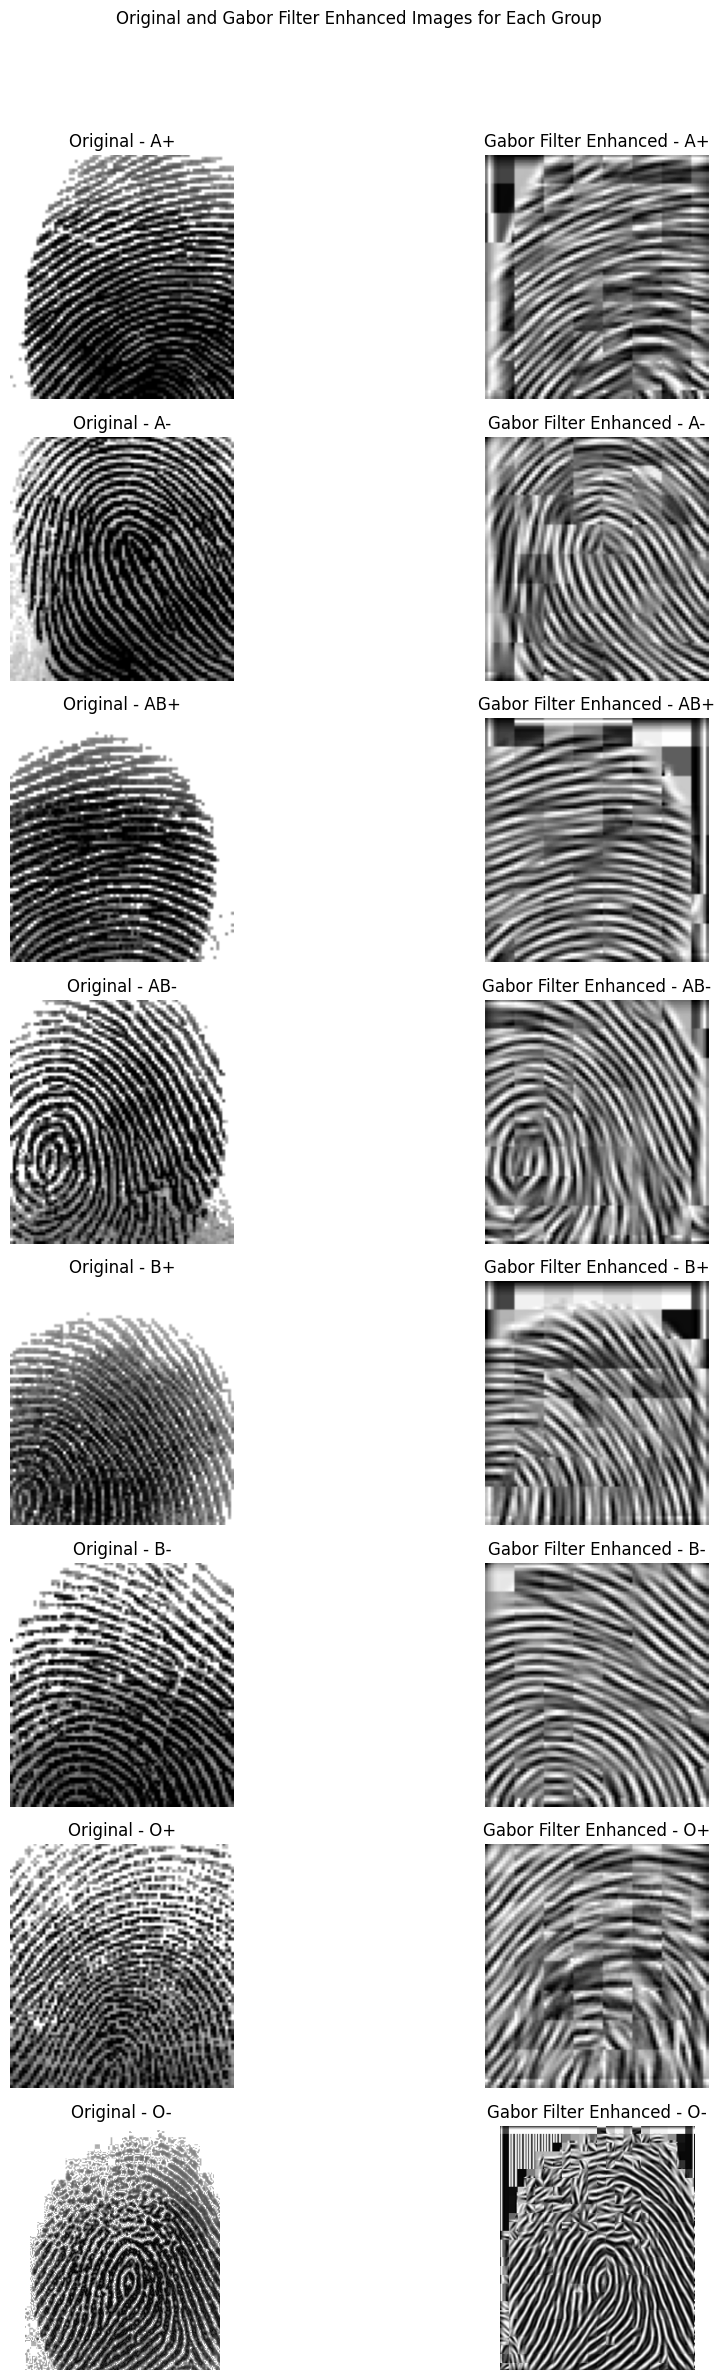

In [12]:
# Display original and enhanced images per group
fig, axs = plt.subplots(len(processed_images), 2, figsize=(12, 25))
fig.suptitle("Original and Gabor Filter Enhanced Images for Each Group")

for i, (group, images) in enumerate(processed_images.items()):
    # Original image (first image in the group)
    original_image = images[0]
    axs[i, 0].imshow(original_image, cmap='gray')
    axs[i, 0].set_title(f"Original - {group}")
    
    # Enhanced image (first image in the group)
    enhanced_image = gabor_filtered_images[group][0]
    axs[i, 1].imshow(enhanced_image, cmap='gray')
    axs[i, 1].set_title(f"Gabor Filter Enhanced - {group}")
    
    # Turn off axis for all subplots
    for ax in axs[i, :]:
        ax.axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Display sample images after all the above steps

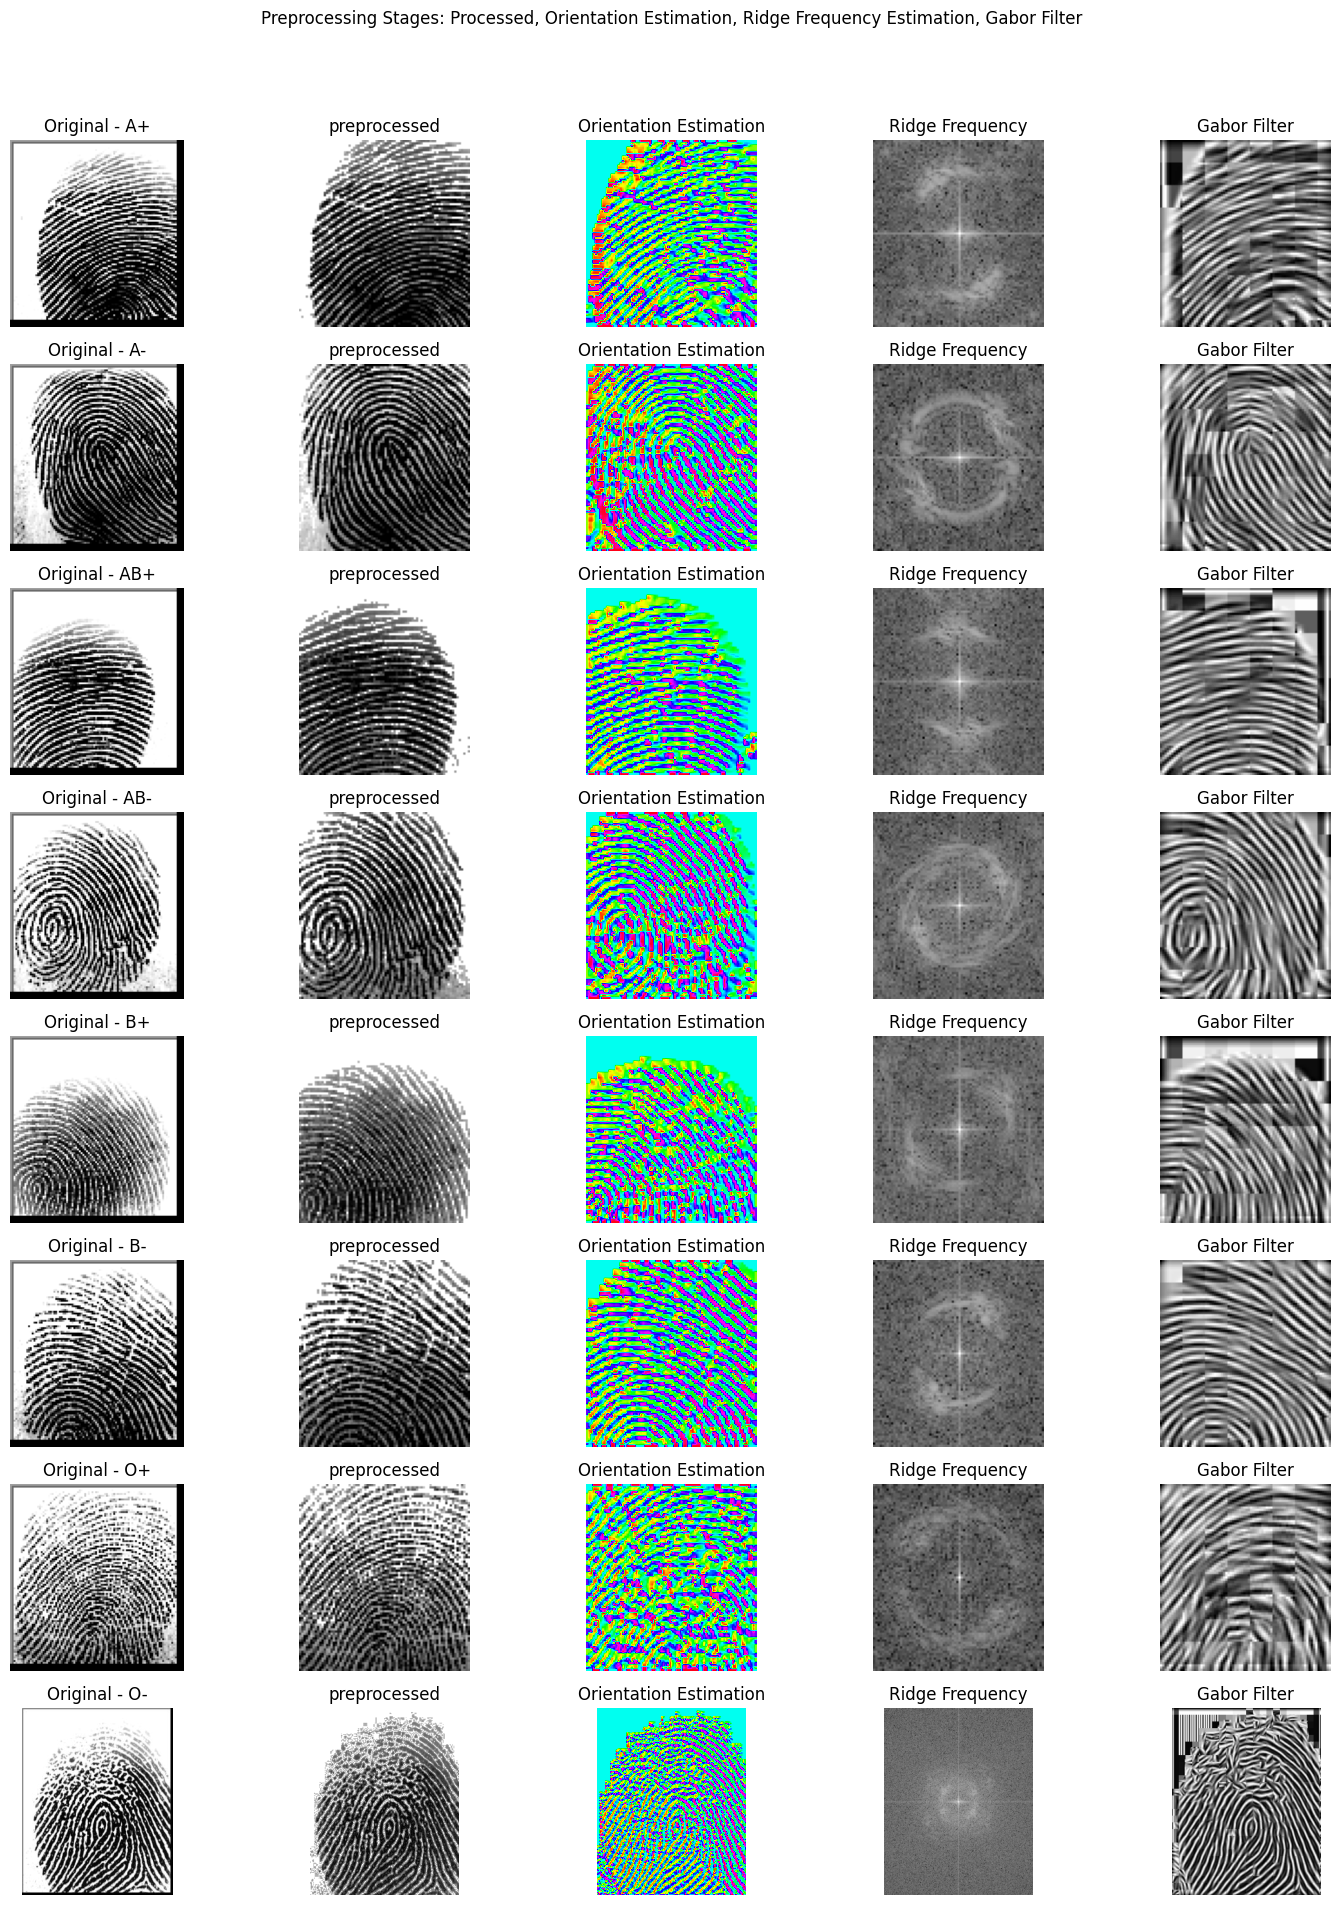

In [13]:
# Display sample images for each preprocessing step
fig, axs = plt.subplots(len(blood_groups), 5, figsize=(15, 20))
fig.suptitle("Preprocessing Stages: Processed, Orientation Estimation, Ridge Frequency Estimation, Gabor Filter")

for i, group in enumerate(blood_groups):
    # Original
    axs[i, 0].imshow(cv2.imread(dataset[group][0], cv2.IMREAD_GRAYSCALE), cmap='gray')
    axs[i, 0].set_title(f"Original - {group}")
    
    # Normalized
    axs[i, 1].imshow(processed_images[group][0], cmap='gray')
    axs[i, 1].set_title("preprocessed")
    
    # Orientation Estimation
    axs[i, 2].imshow(orientation_images[group][0], cmap='hsv')
    axs[i, 2].set_title("Orientation Estimation")
    
    # Ridge Frequency Estimation
    axs[i, 3].imshow(frequency_images[group][0], cmap='gray')
    axs[i, 3].set_title("Ridge Frequency")
    
    # Gabor Filter
    axs[i, 4].imshow(gabor_filtered_images[group][0], cmap='gray')
    axs[i, 4].set_title("Gabor Filter")
    
    for ax in axs[i, :]:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


# **Feature Extraction**
1. **Ridge Feature Extraction**
2. **Minutiae Feature Extraction**
3. **Local Binary Pattern Feature Extraction**
4. **Orientation Feature Extraction**
5. **Wavelet Features Extraction**

In [15]:
import cv2
import numpy as np
import pywt
from skimage.feature import local_binary_pattern
from skimage.morphology import thin, disk
from skimage.morphology import skeletonize
from skimage.util import invert
from scipy.ndimage import convolve
import pandas as pd

# Minutiae Features
def extract_minutiae_features(image):
    skeleton = thin(image > 127)
    struct_element = disk(1)
    convolved = convolve(skeleton.astype(np.uint8), struct_element)
    ridge_endings = np.sum(convolved == 1)
    bifurcations = np.sum(convolved == 3)
    return {"ridge_endings": ridge_endings, "bifurcations": bifurcations}

# Ridge Features
def extract_ridge_features(image, ridge_frequency):
    skeleton = skeletonize(invert(image // 255)) 
    distance_transform = cv2.distanceTransform(255 - image, cv2.DIST_L2, 3)
    ridge_thickness = 2 * distance_transform[skeleton > 0]
    mean_ridge_thickness = np.mean(ridge_thickness)
    
    valleys = 255 - image
    valley_skeleton = skeletonize(invert(valleys // 255))  
    distance_transform = cv2.distanceTransform(image, cv2.DIST_L2, 3)
    valley_thickness = 2 * distance_transform[valley_skeleton > 0]  
    mean_valley_thickness = np.mean(valley_thickness)

    return {
        "ridge_thickness": mean_ridge_thickness,
        "valley_thickness": mean_valley_thickness,
        "ridge_frequency": ridge_frequency,
    }

# LBP Features
def extract_lbp_features(image):

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= hist.sum()
    return {f"lbp_{i}": v for i, v in enumerate(hist)}

# Orientation Histogram
def extract_orientation_features(orientation_image):
  
    hist, _ = np.histogram(orientation_image, bins=8, range=(-180, 180))
    hist = hist.astype("float")
    hist /= hist.sum()
    return {f"orientation_{i}": v for i, v in enumerate(hist)}

# Wavelet Features
def extract_wavelet_features(image):

    coeffs = pywt.wavedec2(image, wavelet="db1", level=2)
    features = {}
    for i, coeff in enumerate(coeffs):
        if isinstance(coeff, tuple):  # Detail coefficients (horizontal, vertical, diagonal)
            features[f"wavelet_mean_{i}_h"] = np.mean(coeff[0])
            features[f"wavelet_var_{i}_h"] = np.var(coeff[0])
            features[f"wavelet_mean_{i}_v"] = np.mean(coeff[1])
            features[f"wavelet_var_{i}_v"] = np.var(coeff[1])
            features[f"wavelet_mean_{i}_d"] = np.mean(coeff[2])
            features[f"wavelet_var_{i}_d"] = np.var(coeff[2])
        else:  # Approximation coefficients
            features[f"wavelet_mean_{i}"] = np.mean(coeff)
            features[f"wavelet_var_{i}"] = np.var(coeff)
    return features

In [16]:
def extract_features(image, orientation_image, ridge_frequency, gabor_image):
 
    features = {}
    
    # Minutiae features
    features.update(extract_minutiae_features(gabor_image))
    
    # Ridge features
    features.update(extract_ridge_features(image, ridge_frequency))
    
    # LBP features
    features.update(extract_lbp_features(gabor_image))
    
    # Orientation features
    features.update(extract_orientation_features(orientation_image))
    
    # Wavelet features
    features.update(extract_wavelet_features(gabor_image))
    
    return features

# Dataset Preparation from the Extracted Features

In [17]:
# Dataset preparation
def prepare_dataset(dataset, orientation_images, ridge_frequencies, gabor_images):
  
    final_dataset = []
    
    for group in blood_groups:
        for idx, image in enumerate(dataset[group]):
            features = extract_features(
                image,
                orientation_images[group][idx],
                ridge_frequencies[group][idx],
                gabor_images[group][idx],
            )
            features["blood_group"] = group
            final_dataset.append(features)
    
    # Convert to pandas DataFrame
    return pd.DataFrame(final_dataset)

# Example usage (after preprocessing steps)
final_df = prepare_dataset(
    processed_images,
    orientation_images,
    frequency_images,
    gabor_filtered_images,
)
final_df.head()

ridge_endings  bifurcations  ridge_thickness  valley_thickness  \
0           1680           494         6.190333          1.273333   
1           1710           457         1.881911          2.978911   
2           1577           339         3.191133          2.094133   
3           1476           426         3.007000          2.306355   
4           1651           415         1.973978          2.370333   

                                     ridge_frequency     lbp_0     lbp_1  \
0  [[119.74340228547828, 143.29451740503788, 144....  0.076252  0.115568   
1  [[162.62191001333719, 155.33463150688914, 139....  0.083703  0.114458   
2  [[146.54521593992735, 151.31831432708685, 151....  0.092422  0.105422   
3  [[144.8284215510539, 155.9743316533877, 140.54...  0.050888  0.102568   
4  [[134.89331052041555, 155.02401325134724, 141....  0.092422  0.105897   

      lbp_2     lbp_3     lbp_4  ...  wavelet_var_1_v  wavelet_mean_1_d  \
0  0.028852  0.062460  0.280438  ...      5771.615692          1.137218   
1  0.033608  0.048351  0.319277  ...      3121.697807          0.348997   
2  0.037571  0.054851  0.279803  ...      4899.517189          8.517544   
3  0.037730  0.075143  0.257768  ...      7224.696024         -2.058897   
4  0.025523  0.058497  0.311668  ...      4918.646516          3.538847   

   wavelet_var_1_d  wavelet_mean_2_h  wavelet_var_2_h  wavelet_mean_2_v  \
0      5975.884523          1.245927      3845.309351          1.104323   
1      7426.083558          0.237155      5812.649114          0.208960   
2      9549.674504         -0.504386      3959.626234          0.364662   
3      4634.336757          1.060777      3236.441168          0.271303   
4     11641.745358          0.289474      5647.251731          0.146617   

   wavelet_var_2_v  wavelet_mean_2_d  wavelet_var_2_d  blood_group  
0      1425.131504         -0.059211       548.883242           A+  
1       985.644776         -0.042920       629.107650           A+  
2      1646.551546         -0.107769       803.022534           A+  
3      1523.730906          0.002506       283.709267           A+  
4      1624.001373         -0.062030       698.260250           A+  

[5 rows x 37 columns]

# Data Preprocessing

In [18]:
final_df.shape

(6000, 37)

In [19]:
final_df.dtypes

ridge_endings         int32
bifurcations          int32
ridge_thickness     float32
valley_thickness    float32
ridge_frequency      object
lbp_0               float64
lbp_1               float64
lbp_2               float64
lbp_3               float64
lbp_4               float64
lbp_5               float64
lbp_6               float64
lbp_7               float64
lbp_8               float64
orientation_0       float64
orientation_1       float64
orientation_2       float64
orientation_3       float64
orientation_4       float64
orientation_5       float64
orientation_6       float64
orientation_7       float64
wavelet_mean_0      float64
wavelet_var_0       float64
wavelet_mean_1_h    float64
wavelet_var_1_h     float64
wavelet_mean_1_v    float64
wavelet_var_1_v     float64
wavelet_mean_1_d    float64
wavelet_var_1_d     float64
wavelet_mean_2_h    float64
wavelet_var_2_h     float64
wavelet_mean_2_v    float64
wavelet_var_2_v     float64
wavelet_mean_2_d    float64
wavelet_var_2_d     

In [20]:
final_df.describe()

ridge_endings  bifurcations  ridge_thickness  valley_thickness  \
count    6000.000000   6000.000000      6000.000000       6000.000000   
mean     1659.945000    479.342333        11.465584          3.087592   
std       817.174524    276.983019        11.704302          3.847649   
min      1009.000000     69.000000         0.000000          0.000000   
25%      1469.000000    401.000000         3.431444          1.273333   
50%      1585.000000    454.000000         7.223356          1.669689   
75%      1706.000000    510.000000        15.303401          2.794778   
max     16605.000000   6556.000000       115.414528         53.550201   

             lbp_0        lbp_1        lbp_2        lbp_3        lbp_4  \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean      0.071206     0.106853     0.034775     0.064742     0.281309   
std       0.017042     0.017068     0.008876     0.014582     0.034712   
min       0.023621     0.039585     0.013298     0.021718     0.171370   
25%       0.058814     0.096227     0.028060     0.054692     0.260938   
50%       0.071179     0.106531     0.034242     0.064046     0.280279   
75%       0.083386     0.117153     0.040900     0.074350     0.298867   
max       0.128408     0.185162     0.062936     0.110495     0.531316   

             lbp_5  ...  wavelet_mean_1_v  wavelet_var_1_v  wavelet_mean_1_d  \
count  6000.000000  ...       6000.000000      6000.000000       6000.000000   
mean      0.095168  ...         -0.057356      8846.250451          0.055462   
std       0.039706  ...          4.203115      3929.120715          2.139897   
min       0.017438  ...        -31.567043       773.721155        -10.078321   
25%       0.065314  ...         -2.421679      5904.479902         -1.188127   
50%       0.088142  ...         -0.124373      8661.767105          0.059837   
75%       0.119214  ...          2.227757     11495.196013          1.298246   
max       0.296449  ...         31.233709     28787.609852         11.609649   

       wavelet_var_1_d  wavelet_mean_2_h  wavelet_var_2_h  wavelet_mean_2_v  \
count      6000.000000       6000.000000      6000.000000       6000.000000   
mean       6444.300256          0.484183      3300.598810          0.096413   
std        2563.511657          1.002742      1346.644814          0.593416   
min        1174.344150         -4.637531       665.239051         -2.228070   
25%        4487.457422         -0.017152      2287.644010         -0.263784   
50%        5999.906322          0.646147      3059.041741          0.096021   
75%        7944.723978          1.139254      4108.852876          0.460840   
max       20717.988094          3.248747      8586.301824          2.364348   

       wavelet_var_2_v  wavelet_mean_2_d  wavelet_var_2_d  
count      6000.000000       6000.000000      6000.000000  
mean       2133.019261         -0.001504       475.328592  
std         903.009206          0.051271       206.721247  
min         309.692878         -0.256579        52.253888  
25%        1472.262846         -0.034461       318.004485  
50%        2036.137224         -0.002193       459.945976  
75%        2680.854519          0.031955       613.617435  
max        7321.979938          0.216479      1369.394399  

[8 rows x 35 columns]

# EDA and Visualization

In [21]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ridge_endings     6000 non-null   int32  
 1   bifurcations      6000 non-null   int32  
 2   ridge_thickness   6000 non-null   float32
 3   valley_thickness  6000 non-null   float32
 4   ridge_frequency   6000 non-null   object 
 5   lbp_0             6000 non-null   float64
 6   lbp_1             6000 non-null   float64
 7   lbp_2             6000 non-null   float64
 8   lbp_3             6000 non-null   float64
 9   lbp_4             6000 non-null   float64
 10  lbp_5             6000 non-null   float64
 11  lbp_6             6000 non-null   float64
 12  lbp_7             6000 non-null   float64
 13  lbp_8             6000 non-null   float64
 14  orientation_0     6000 non-null   float64
 15  orientation_1     6000 non-null   float64
 16  orientation_2     6000 non-null   float64


In [22]:
final_df.describe()

ridge_endings  bifurcations  ridge_thickness  valley_thickness  \
count    6000.000000   6000.000000      6000.000000       6000.000000   
mean     1659.945000    479.342333        11.465584          3.087592   
std       817.174524    276.983019        11.704302          3.847649   
min      1009.000000     69.000000         0.000000          0.000000   
25%      1469.000000    401.000000         3.431444          1.273333   
50%      1585.000000    454.000000         7.223356          1.669689   
75%      1706.000000    510.000000        15.303401          2.794778   
max     16605.000000   6556.000000       115.414528         53.550201   

             lbp_0        lbp_1        lbp_2        lbp_3        lbp_4  \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean      0.071206     0.106853     0.034775     0.064742     0.281309   
std       0.017042     0.017068     0.008876     0.014582     0.034712   
min       0.023621     0.039585     0.013298     0.021718     0.171370   
25%       0.058814     0.096227     0.028060     0.054692     0.260938   
50%       0.071179     0.106531     0.034242     0.064046     0.280279   
75%       0.083386     0.117153     0.040900     0.074350     0.298867   
max       0.128408     0.185162     0.062936     0.110495     0.531316   

             lbp_5  ...  wavelet_mean_1_v  wavelet_var_1_v  wavelet_mean_1_d  \
count  6000.000000  ...       6000.000000      6000.000000       6000.000000   
mean      0.095168  ...         -0.057356      8846.250451          0.055462   
std       0.039706  ...          4.203115      3929.120715          2.139897   
min       0.017438  ...        -31.567043       773.721155        -10.078321   
25%       0.065314  ...         -2.421679      5904.479902         -1.188127   
50%       0.088142  ...         -0.124373      8661.767105          0.059837   
75%       0.119214  ...          2.227757     11495.196013          1.298246   
max       0.296449  ...         31.233709     28787.609852         11.609649   

       wavelet_var_1_d  wavelet_mean_2_h  wavelet_var_2_h  wavelet_mean_2_v  \
count      6000.000000       6000.000000      6000.000000       6000.000000   
mean       6444.300256          0.484183      3300.598810          0.096413   
std        2563.511657          1.002742      1346.644814          0.593416   
min        1174.344150         -4.637531       665.239051         -2.228070   
25%        4487.457422         -0.017152      2287.644010         -0.263784   
50%        5999.906322          0.646147      3059.041741          0.096021   
75%        7944.723978          1.139254      4108.852876          0.460840   
max       20717.988094          3.248747      8586.301824          2.364348   

       wavelet_var_2_v  wavelet_mean_2_d  wavelet_var_2_d  
count      6000.000000       6000.000000      6000.000000  
mean       2133.019261         -0.001504       475.328592  
std         903.009206          0.051271       206.721247  
min         309.692878         -0.256579        52.253888  
25%        1472.262846         -0.034461       318.004485  
50%        2036.137224         -0.002193       459.945976  
75%        2680.854519          0.031955       613.617435  
max        7321.979938          0.216479      1369.394399  

[8 rows x 35 columns]

In [23]:
final_df.isnull().sum()

ridge_endings       0
bifurcations        0
ridge_thickness     0
valley_thickness    0
ridge_frequency     0
lbp_0               0
lbp_1               0
lbp_2               0
lbp_3               0
lbp_4               0
lbp_5               0
lbp_6               0
lbp_7               0
lbp_8               0
orientation_0       0
orientation_1       0
orientation_2       0
orientation_3       0
orientation_4       0
orientation_5       0
orientation_6       0
orientation_7       0
wavelet_mean_0      0
wavelet_var_0       0
wavelet_mean_1_h    0
wavelet_var_1_h     0
wavelet_mean_1_v    0
wavelet_var_1_v     0
wavelet_mean_1_d    0
wavelet_var_1_d     0
wavelet_mean_2_h    0
wavelet_var_2_h     0
wavelet_mean_2_v    0
wavelet_var_2_v     0
wavelet_mean_2_d    0
wavelet_var_2_d     0
blood_group         0
dtype: int64

In [24]:
import pandas as pd
import numpy as np

# Assuming 'df' is the dataframe containing your data
numeric_columns = final_df.select_dtypes(include=['float64', 'int32']).columns

# Function to remove outliers based on IQR
def remove_outliers(df, numeric_columns):
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier thresholds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Apply the function to remove outliers
clean_df = remove_outliers(final_df, numeric_columns)

# Check the shape of the cleaned dataframe
print(clean_df.shape)


(3882, 37)


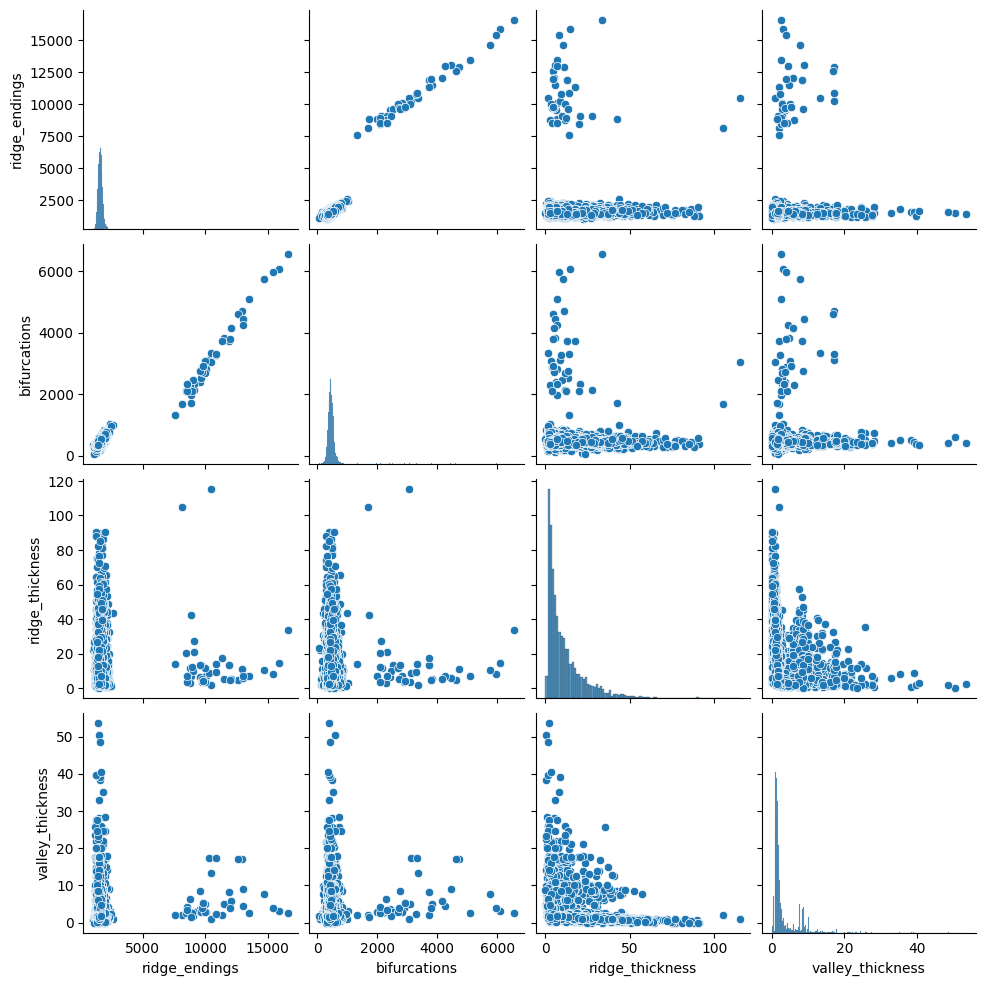

In [25]:
selected_columns = ['ridge_endings', 'bifurcations', 'ridge_thickness', 'valley_thickness']
sns.pairplot(final_df[selected_columns])
plt.show()

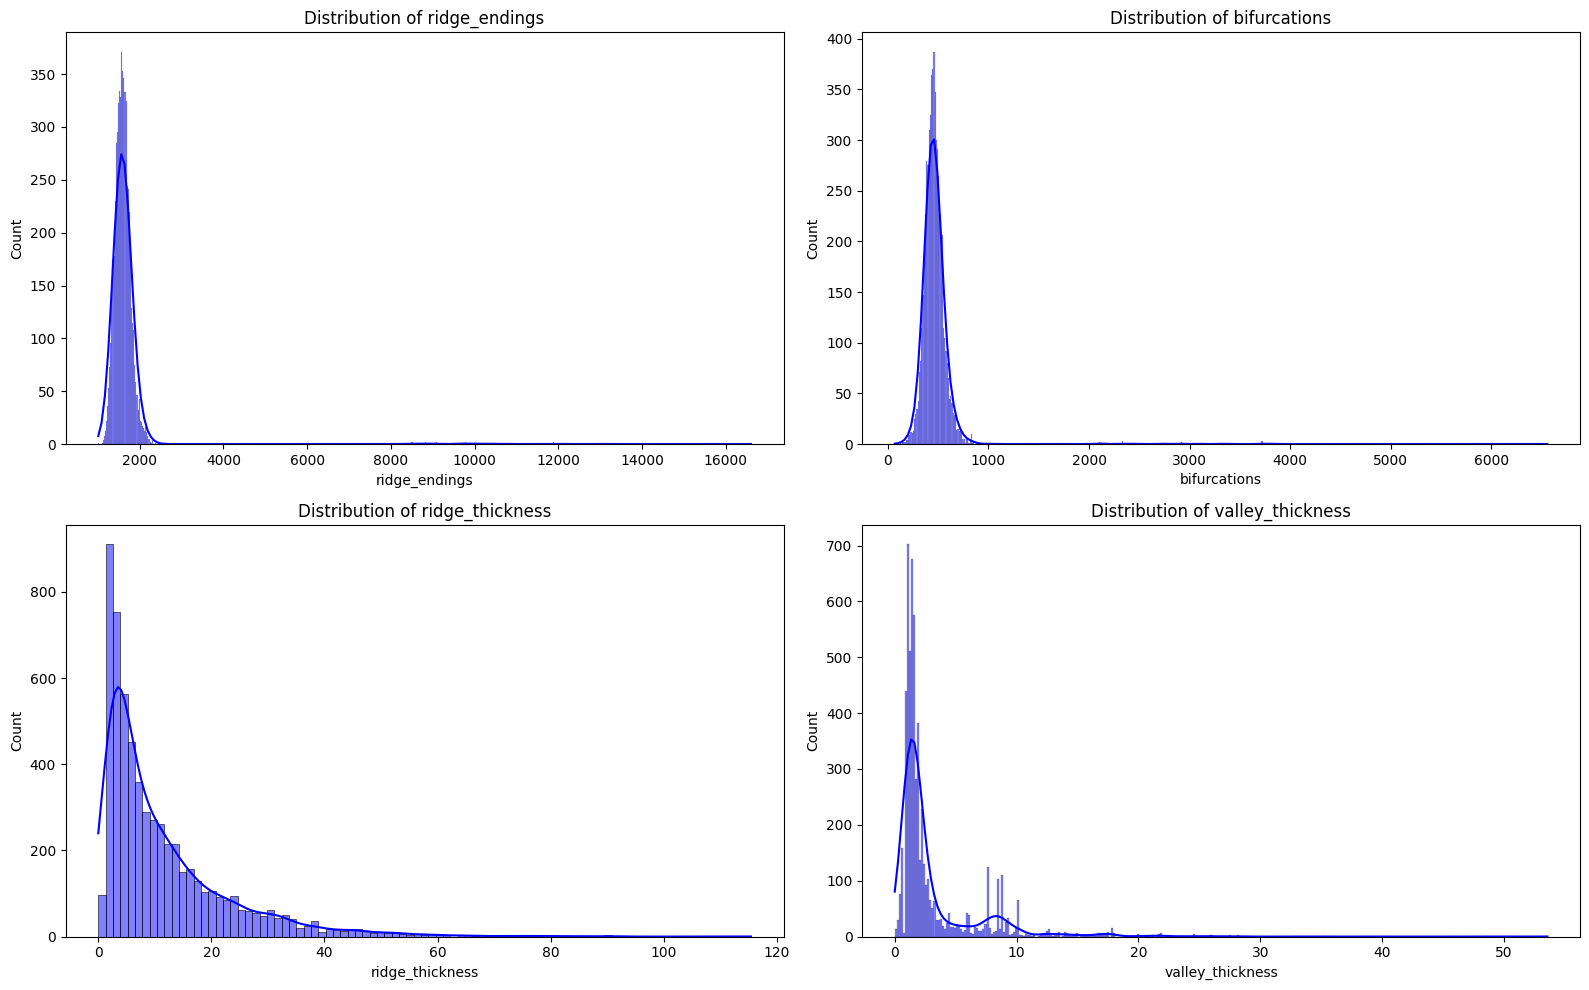

In [26]:
# Distribution plots for specific features
plt.figure(figsize=(16, 10))
for i, column in enumerate(selected_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(final_df[column], kde=True, color='blue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

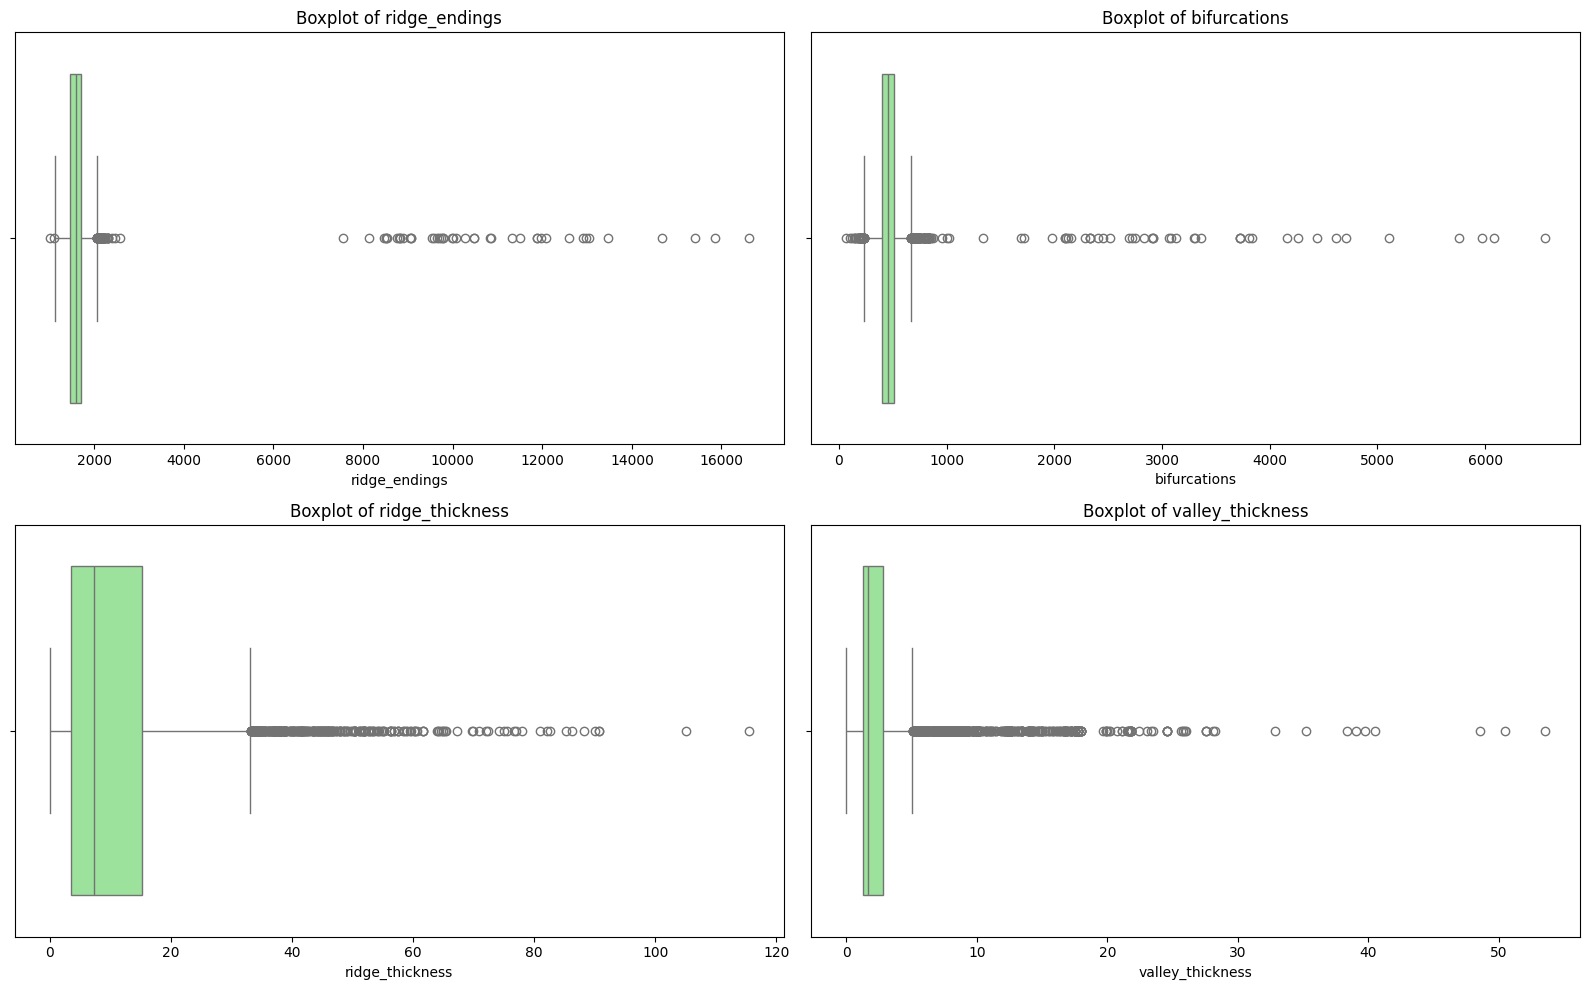

In [27]:
# Boxplots for selected features to detect outliers
plt.figure(figsize=(16, 10))
for i, column in enumerate(selected_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=final_df[column], color='lightgreen')
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

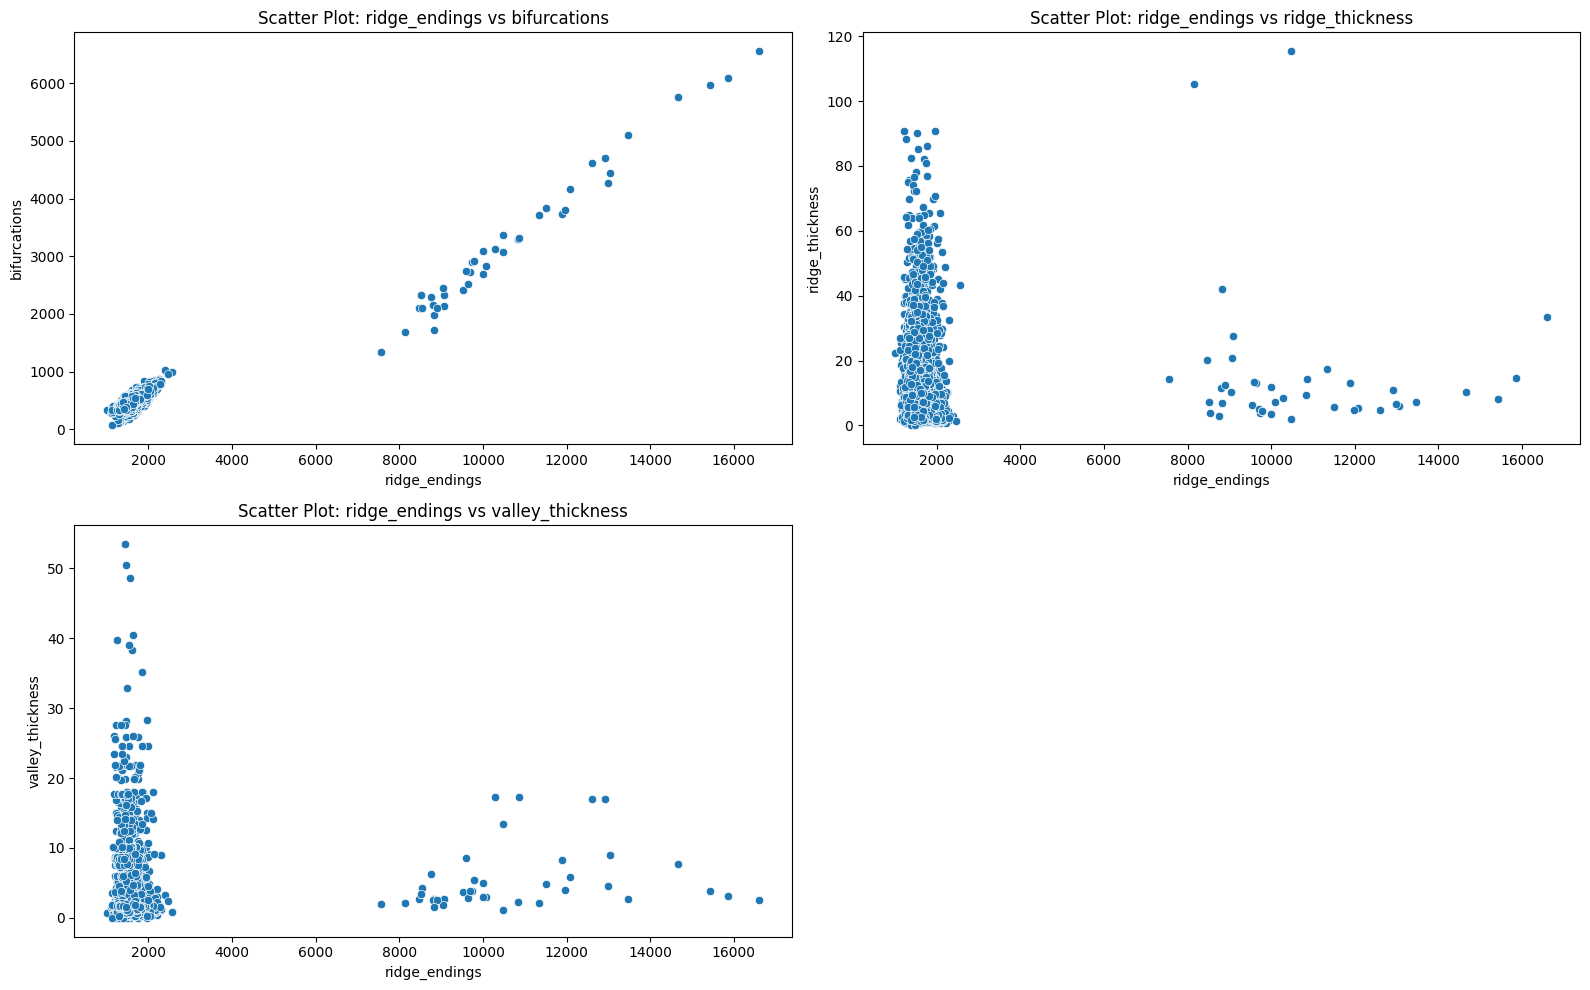

In [28]:
# Visualize relationships between features using scatter plots
plt.figure(figsize=(16, 10))
for i, column in enumerate(selected_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=final_df['ridge_endings'], y=final_df[column])
    plt.title(f'Scatter Plot: ridge_endings vs {column}')
plt.tight_layout()
plt.show()


LBP Feature Columns: ['lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7', 'lbp_8']


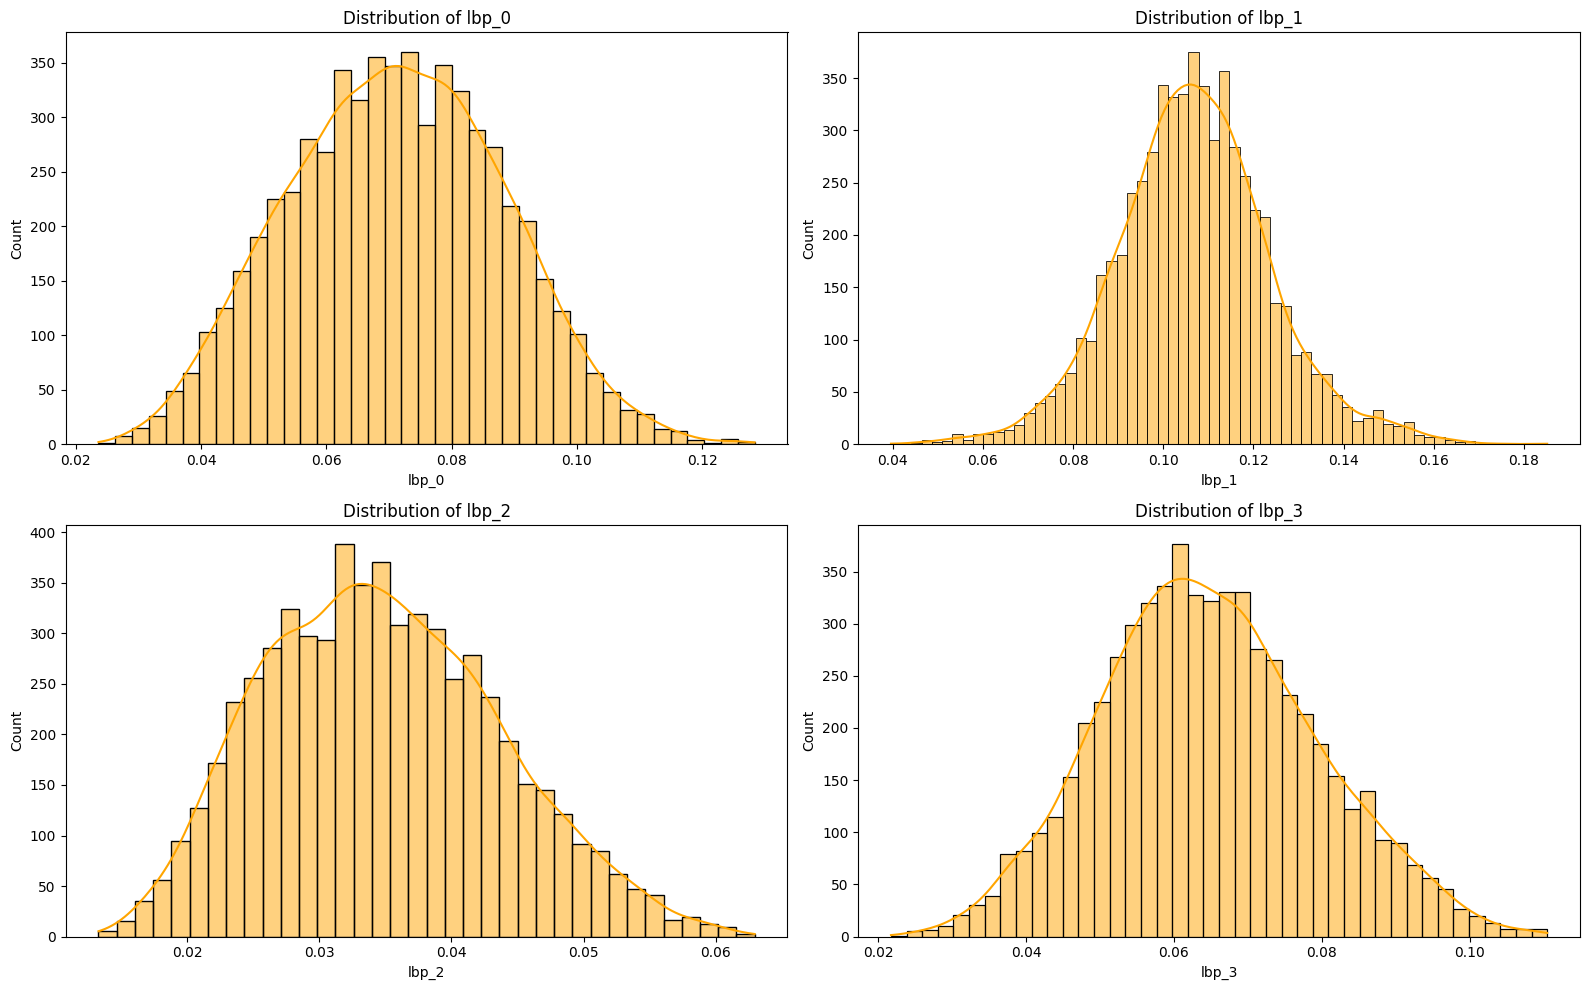

In [29]:
# Analyzing LBP features (assuming they are prefixed with 'lbp_')
lbp_columns = [col for col in final_df.columns if 'lbp_' in col]
print("\nLBP Feature Columns:", lbp_columns)

plt.figure(figsize=(16, 10))
for i, column in enumerate(lbp_columns[:4], 1):  # Visualize only the first 4 for brevity
    plt.subplot(2, 2, i)
    sns.histplot(final_df[column], kde=True, color='orange')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


Wavelet Feature Columns: ['wavelet_mean_0', 'wavelet_var_0', 'wavelet_mean_1_h', 'wavelet_var_1_h', 'wavelet_mean_1_v', 'wavelet_var_1_v', 'wavelet_mean_1_d', 'wavelet_var_1_d', 'wavelet_mean_2_h', 'wavelet_var_2_h', 'wavelet_mean_2_v', 'wavelet_var_2_v', 'wavelet_mean_2_d', 'wavelet_var_2_d']


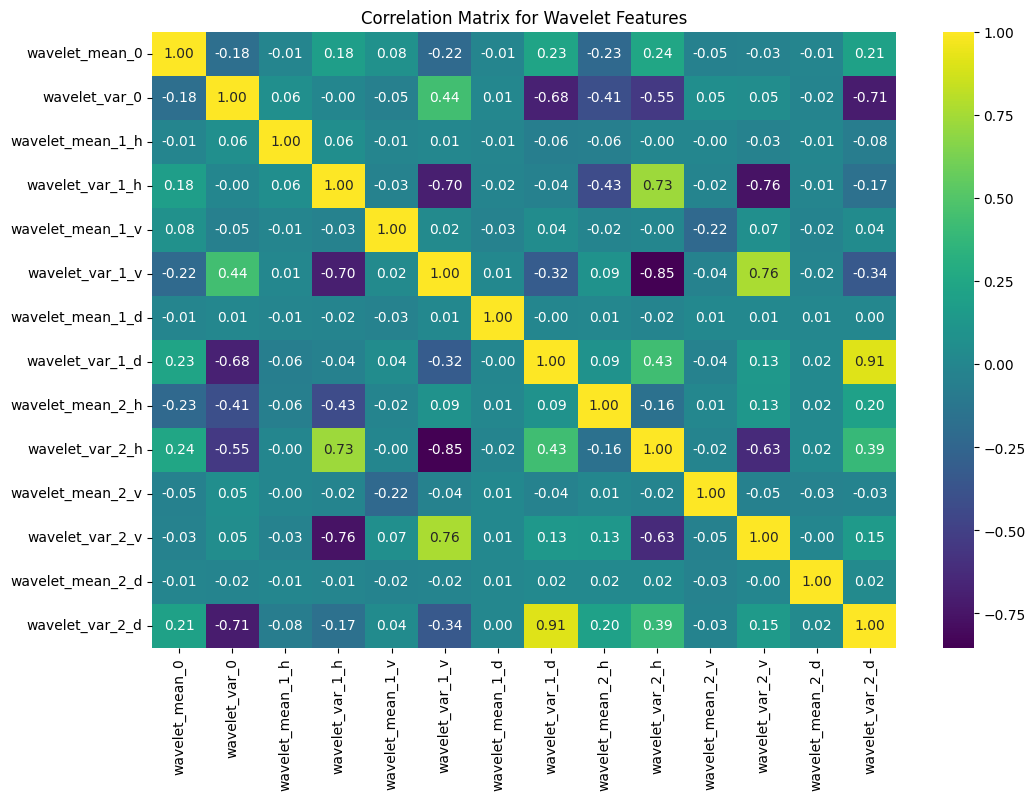

In [30]:
# Wavelet feature analysis (assuming they are prefixed with 'wavelet_')
wavelet_columns = [col for col in final_df.columns if 'wavelet_' in col]
print("\nWavelet Feature Columns:", wavelet_columns)

# Heatmap for wavelet features
wavelet_corr = final_df[wavelet_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(wavelet_corr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Matrix for Wavelet Features")
plt.show()

# Separate the training and testing dataset

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

# Encode the categorical target variable
label_encoder = LabelEncoder()
final_df['blood_group_encoded'] = label_encoder.fit_transform(final_df['blood_group'])

# Separate features and target variable
X = final_df.drop(columns=['blood_group', 'blood_group_encoded'])
y = final_df['blood_group_encoded']

# Check for and fix object columns
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].apply(
        lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else float(x)
    )

# Verify all columns are numeric
assert all(X.dtypes != 'object'), "Some columns are still not numeric."

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Fitting and Evaluation

In [33]:
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

# Train, predict and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    

    # For classification models, use classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} (Classification) Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
        
    print("\n")
    print("-" * 50)
    

Logistic Regression (Classification) Accuracy: 0.8000
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       135
           1       0.78      0.73      0.75       216
           2       0.80      0.80      0.80       138
           3       0.78      0.83      0.81       132
           4       0.83      0.79      0.81       129
           5       0.83      0.89      0.86       140
           6       0.75      0.83      0.79       172
           7       0.78      0.71      0.75       138

    accuracy                           0.80      1200
   macro avg       0.80      0.80      0.80      1200
weighted avg       0.80      0.80      0.80      1200



--------------------------------------------------
SVM (Classification) Accuracy: 0.7942
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       135
           1       0.77      0.75      0.76       216
           2       0.80      0.79      0.

# Evaluation after removing outliers
Logistic Regression (Classification) Accuracy: 0.7749
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        54
           1       0.74      0.81      0.78       149
           2       0.80      0.80      0.80        96
           3       0.80      0.77      0.78       113
           4       0.78      0.80      0.79        82
           5       0.85      0.85      0.85        55
           6       0.81      0.67      0.73       113
           7       0.73      0.75      0.74       111

    accuracy                           0.77       773
   macro avg       0.78      0.78      0.78       773
weighted avg       0.78      0.77      0.77       773



--------------------------------------------------
SVM (Classification) Accuracy: 0.7607
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        54
           1       0.71      0.78      0.74       149
           2       0.77      0.80      0.79        96
           3       0.79      0.72      0.75       113
           4       0.77      0.80      0.79        82
           5       0.81      0.84      0.82        55
           6       0.83      0.65      0.73       113
           7       0.72      0.77      0.74       111

    accuracy                           0.76       773
   macro avg       0.77      0.77      0.77       773
weighted avg       0.76      0.76      0.76       773



--------------------------------------------------
KNN (Classification) Accuracy: 0.6003
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        54
           1       0.54      0.72      0.62       149
           2       0.55      0.74      0.63        96
           3       0.67      0.58      0.62       113
           4       0.69      0.56      0.62        82
           5       0.66      0.56      0.61        55
           6       0.65      0.50      0.57       113
           7       0.69      0.56      0.62       111

    accuracy                           0.60       773
   macro avg       0.61      0.58      0.59       773
weighted avg       0.61      0.60      0.60       773



--------------------------------------------------
Random Forest (Classification) Accuracy: 0.7426
              precision    recall  f1-score   support

           0       0.85      0.52      0.64        54
           1       0.67      0.72      0.69       149
           2       0.74      0.84      0.79        96
           3       0.82      0.78      0.80       113
           4       0.77      0.78      0.78        82
           5       0.79      0.76      0.78        55
           6       0.70      0.72      0.71       113
           7       0.73      0.75      0.74       111

    accuracy                           0.74       773
   macro avg       0.76      0.73      0.74       773
weighted avg       0.75      0.74      0.74       773



--------------------------------------------------
Gradient Boost (Classification) Accuracy: 0.7503
              precision    recall  f1-score   support

           0       0.82      0.61      0.70        54
           1       0.70      0.76      0.73       149
           2       0.79      0.81      0.80        96
           3       0.79      0.78      0.79       113
           4       0.74      0.79      0.76        82
           5       0.77      0.78      0.77        55
           6       0.78      0.70      0.74       113
           7       0.69      0.73      0.71       111

    accuracy                           0.75       773
   macro avg       0.76      0.75      0.75       773
weighted avg       0.75      0.75      0.75       773



--------------------------------------------------
XGBoost (Classification) Accuracy: 0.7594
              precision    recall  f1-score   support

           0       0.79      0.63      0.70        54
           1       0.73      0.74      0.74       149
           2       0.80      0.82      0.81        96
           3       0.75      0.77      0.76       113
           4       0.84      0.80      0.82        82
           5       0.77      0.87      0.82        55
           6       0.75      0.67      0.71       113
           7       0.72      0.77      0.74       111

    accuracy                           0.76       773
   macro avg       0.77      0.76      0.76       773
weighted avg       0.76      0.76      0.76       773



--------------------------------------------------


# Evaluation result with cross validation
Logistic Regression (Classification) Accuracy: 0.8042
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       135
           1       0.79      0.74      0.76       216
           2       0.80      0.82      0.81       138
           3       0.76      0.83      0.79       132
           4       0.84      0.78      0.81       129
           5       0.82      0.88      0.85       140
           6       0.77      0.84      0.80       172
           7       0.80      0.72      0.76       138

    accuracy                           0.80      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.81      0.80      0.80      1200

Cross-validated accuracy: 0.7752


--------------------------------------------------
SVM (Classification) Accuracy: 0.7958
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       135
           1       0.74      0.73      0.73       216
           2       0.81      0.81      0.81       138
           3       0.77      0.85      0.81       132
           4       0.82      0.75      0.78       129
           5       0.82      0.86      0.84       140
           6       0.76      0.81      0.78       172
           7       0.83      0.72      0.77       138

    accuracy                           0.80      1200
   macro avg       0.80      0.80      0.80      1200
weighted avg       0.80      0.80      0.80      1200

Cross-validated accuracy: 0.7773


--------------------------------------------------
Random Forest (Classification) Accuracy: 0.7733
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       135
           1       0.75      0.71      0.73       216
           2       0.75      0.81      0.78       138
           3       0.73      0.78      0.75       132
           4       0.80      0.75      0.78       129
           5       0.83      0.86      0.85       140
           6       0.71      0.83      0.77       172
           7       0.80      0.70      0.75       138

    accuracy                           0.77      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.77      0.77      1200

Cross-validated accuracy: 0.7475


--------------------------------------------------
Linear Regression (Regression) Metrics:
MSE: 4.5561, RMSE: 2.1345, R²: 0.1526, MAE: 1.8938


--------------------------------------------------
Gradient Boost (Classification) Accuracy: 0.7767
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       135
           1       0.73      0.73      0.73       216
           2       0.75      0.80      0.77       138
           3       0.72      0.82      0.77       132
           4       0.80      0.73      0.76       129
           5       0.83      0.85      0.84       140
           6       0.73      0.81      0.77       172
           7       0.83      0.70      0.76       138

    accuracy                           0.78      1200
   macro avg       0.79      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200

Cross-validated accuracy: 0.7521


--------------------------------------------------


# Load the model in pickel form

In [35]:
import pickle

# Save the model using pickle
model=LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully!")


Model saved successfully!
